In [2]:
import pyarrow.parquet as pq
from config import settings , parse_datetime_strings
from pathlib import Path
psd_nperseg = 8192
path_psd = Path(settings.default.path['processed_data']) / f'PSD_{psd_nperseg}.avro'


In [3]:
def get_sensor_axis(sensor_name: str):
    sensor_axis = sensor_name.split('_')[0][-1]
    return sensor_axis

def get_sensor_position(sensor_name: str):
    sensor_position = sensor_name.split('_')[1]
    return sensor_position

def custom_collate_fn(batch):
    # `batch` is a list of samples [(psd1, pos1, axis1), (psd2, pos2, axis2), ...]

    # Stack PSD tensors along a new leading dimension
    psds = torch.stack([item[0] for item in batch])

    # Stack positions and axes (or keep them as lists if that's what you want)
    positions = torch.tensor([item[1] for item in batch])
    axes = torch.tensor([item[2] for item in batch])

    # Return batched tensors
    return psds, positions, axes

# Use the custom collate function in the DataLoader


In [11]:
from typing import Tuple, List, Union
from datetime import datetime
from pathlib import Path
import torch
import numpy as np
import sqlite3
from torch.utils.data import Dataset, DataLoader
from functools import cached_property



torch.manual_seed(1)
class PSDDataset(Dataset):
    def __init__(self, database_path: Union[Path, str], datetime_range: Tuple[datetime, datetime],
                 drop: List[str] = None, transform=None, label_transform=None, preload=False) -> None:
        """
        Initialize the dataset.
        """
        self.database_path = database_path
        self.transform = transform
        self.label_transform = label_transform
        self.drop = set(drop) if drop else set()
        self.preload = preload

        # Connect to the SQLite database
        self.conn = sqlite3.connect(database_path)

        # Get keys within the datetime range
        self.keys = []
        start_ts = datetime_range[0].timestamp()
        end_ts = datetime_range[1].timestamp()
        
        query = '''
        SELECT rowid FROM psd_data WHERE time >= ? AND time <= ?;
        '''
        cursor = self.conn.execute(query, (start_ts, end_ts))
        self.keys = [row[0] for row in cursor]

        self.initialize_dicts()

        # Preload data into memory if requested
        if self.preload:
            self.data = self.preload_data()

    def __len__(self) -> int:
        return len(self.keys)

    def initialize_dicts(self):
        query = '''
        SELECT DISTINCT sensor_name FROM psd_data;
        '''
        cursor = self.conn.execute(query)
        sensor_names = [row[0] for row in cursor]
        sensor_names = {sensor for sensor in sensor_names if sensor not in self.drop}

        axis_names = set(map(get_sensor_axis, sensor_names))
        position_names = set(map(get_sensor_position, sensor_names))

        # Store them as attributes
        self._sensor_names = list(sensor_names)
        self._axis_names = list(axis_names)
        self._position_names = list(position_names)
        
        self._mapping_dict = {sensor: i for i, sensor in enumerate(self._sensor_names)}
        self._mapping_position_dict = {position: i for i, position in enumerate(self._position_names)}
        self._mapping_axis_dict = {axis: i for i, axis in enumerate(self._axis_names)}

    def preload_data(self):
        # Method to load the entire dataset into memory
        data = []
        for key in self.keys:
            query = '''
            SELECT psd, sensor_name FROM psd_data WHERE rowid = ?;
            '''
            cursor = self.conn.execute(query, (key,))
            row = cursor.fetchone()
            if row and row[1] not in self.drop:
                data.append(row)
        return data

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.preload:
            # Use preloaded data
            row = self.data[index]
        else:
            # Query database for the required record
            key = self.keys[index]
            query = '''
            SELECT psd, sensor_name FROM psd_data WHERE rowid = ?;
            '''
            cursor = self.conn.execute(query, (key,))
            row = cursor.fetchone()
        
        if row is None:
            raise IndexError("Index out of range")

        psd = np.frombuffer(row[0], dtype=np.float64)  # Convert to numpy array with float32 type
        sensor_name = row[1]

        # Filter out the rows based on the `drop` attribute
        sensor_position = self._mapping_position_dict[get_sensor_position(sensor_name)]
        sensor_axis = self._mapping_axis_dict[get_sensor_axis(sensor_name)]

        # Convert to tensors
        psd = torch.from_numpy(psd.copy())
        
        # Apply transformations if any
        if self.transform is not None:
            psd = self.transform(psd)
        if self.label_transform is not None:
            sensor_name = self.label_transform(sensor_name)

        return psd, sensor_position, sensor_axis





# Example usage
# Make sure to define database_path and parse_datetime_strings before running this section
database_path = Path(settings.default.path['processed_data']) / f'PSD{psd_nperseg}.db'
range_dt = parse_datetime_strings(settings.split['train'])
training_range = (range_dt['start'], range_dt['end'])
dataset = PSDDataset(database_path, training_range,preload=True)
dataloader = DataLoader(dataset, batch_size=64, num_workers=8, shuffle=True, collate_fn=custom_collate_fn)

from time import time
start = time()
s = start
for i in dataloader:
    print('time', time()-start)
    start = time()
print('total time', time()-s)


KeyboardInterrupt: 

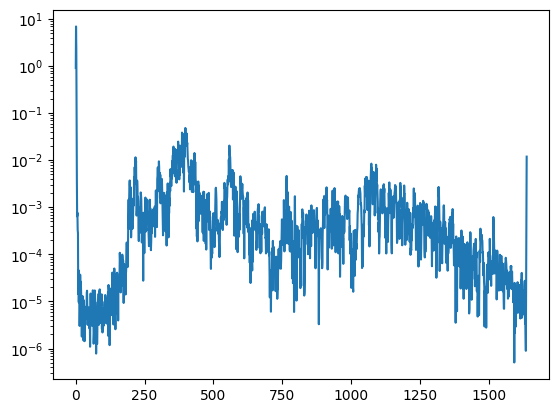

In [12]:
import matplotlib.pyplot as plt
conn = sqlite3.connect(database_path)
query = '''
SELECT psd, sensor_name FROM psd_data WHERE rowid = ?;
'''
cursor = conn.execute(query, (1,))
row = cursor.fetchone()
psd = np.frombuffer(row[0], dtype=np.float64)  # Convert to numpy array with float32 type
plt.plot(psd)
plt.yscale('log')

In [7]:
# dimension is 40000,3000,1 of numpy float 32  compute memory usage 
# 40000*3000*4/1024/1024/1024 = 0.34 


3840.0

In [22]:
dt = parse_datetime_strings(settings.split['train'])
type(dt['start'].timestamp())

float

In [23]:
#query one signal 
query = '''
SELECT psd, sensor_name FROM psd_data WHERE sensor_name = ?;
'''
conn = sqlite3.connect(database_path)
cursor = conn.execute(query, ('ACC3_Z',))
row = cursor.fetchone()
np.frombuffer(row[0],dtype=np.float32).shape 


(3278,)

In [17]:
query = '''
SELECT * FROM psd_data WHERE rowid = ?;
'''
conn = sqlite3.connect(database_path)
cursor = conn.execute(query, (1,))
row = cursor.fetchone()



In [21]:
row[2]

b'\xd7\xfbh\xf5PL\xed?x\xdbl\xd9\xdd\xda\x1b@\xe7\x15\xa9K\'d\x02@s.\xea\x83\xe0y\xb4?\xfc\xeab\xcc\x9b\x1fp?\x9d\xa09!\xd4\x12E?\xc7o\xa3\x15\x07(I?,\xd1 \xfe\x94g5?\xb1\x1f\xab\x13\xc2\x942?DC\xe8$g\xff\xed>\x1bk\xca\xe4\xd6 \x08?\xc2w\x9ek8\x19\xe4>\x14\xf9R2\xd0\xc8\xfd>1!>\xb9LI\xf1>\xb2U\xa3\x11\xa3V\xc9>\x90\xe2\\\xdc\x06u\xdc><\xdc\xda\x11\x87n\x03?\x1b\xb5\x943~\xa3\xf3>\x02\xd8\xc0IH\x9b\xfb>DbO\x90\x18\xd0\xf4>y)/\xbd\xfd\x87\xe7>\x90\xbd)\x8f\xa6\x9f\xd0>\xbcL\xb6\xd2\xc1\x0f\xbe>\x1c\xd1\xed\xdc\xb72\xd3>N\x80\xba\x16d\xb9\xd7>il\xb9\xf4\x80$\xeb>\xd7~\xf9\xd0\\_\xe6>\x8e\xffF~\xc4\xbf\xd3>\xc8o2\x0e5\xf3\xb8>8\x07z\xcf{Z\xe6>h\xfa\xd8@S)\xe1>\xb5C\xde\xa5F\xde\xcc>3pa\xe3\x1e\x08\xb8>\x1a\x96\xa7\xfd\x89\xc4\xc9>\x8a|\xc9\x90\xe2\x97\xd9>hADp\xcbs\xd2>\xc2d\xeaA\xce\xd9\xd1>Zf\x87\x93\x9f\xc7\xde>\x84\xe7(\x0c[,\xe0>Tua\x80\xb1\x18\xd9>\xcec\x1f\xde\x94\x18\xf0>\x9cLI\xc3g\xb9\xf1>X\x84\xe8\xf1u\\\xd9>\xdfE\xe2\\&\xac\xca>D\x82T\x9b\xd5\xc7\xde>\xaeC\x8a\xb2\xe7\xdb\xd2>\

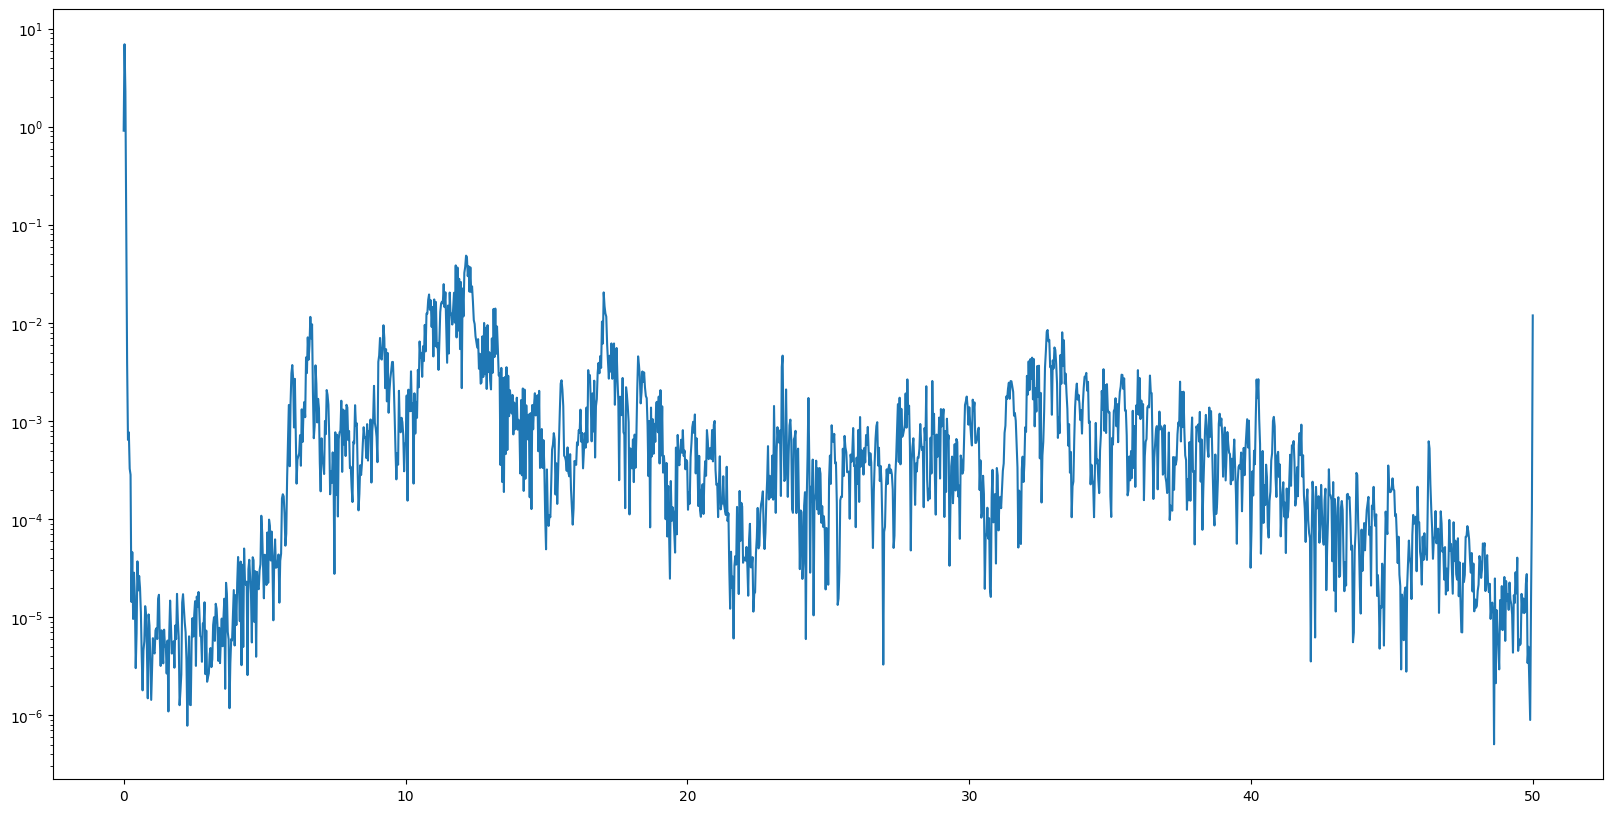

In [24]:
import matplotlib.pyplot as plt
freq = np.arange(0,50,(250/8192))
plt.figure(figsize=(20,10))
plt.plot(freq,np.frombuffer(row[2],dtype=np.float64))
plt.yscale('log')

In [70]:
250/8192

0.030517578125

IndexError: tuple index out of range

In [20]:
row

NameError: name 'row' is not defined

In [16]:
np.array([1,2,3.])

array([1., 2., 3.], dtype=float32)